# Computing the Spin Overlap Patameter

In this script, I will do:
    
    1. Check if the simulation worked fine and do what I expect. 
    
        - Plotting the muz vs. time.
        - Observe the behaviour
        
    2. Compute the Spin Overlap Parameter with the obtained data. 

In [1]:
import os 
import sys

sys.path.insert(0, 'icenumerics/')

import icenumerics as ice
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

ureg = ice.ureg
idx = pd.IndexSlice

import warnings
warnings.filterwarnings("error")


%reload_ext autoreload
%autoreload 2

In [2]:
import magcolloids as mgc

In [3]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 100

mpl.rcParams['font.family'] = 'serif'

Importing the data 

In [4]:
k = 0

In [5]:
load_obj = mgc.trj_lazyread(r"/home/carolina/lammps_script-7/BidisperseColloidalIce_RPM_rate0,069_l22_exp"+str(k)+".lammpstrj", output = ["x","y","z","mux","muy","muz"])

In [6]:
bnd = load_obj.get_bounds()
trj = load_obj.read_trj()

In [7]:
trj

type             x         y    z   mux  muy  muz
frame  id                                                     
0      1        1  1.939710e-15   31.6779  0.0   0.0  0.0  0.0
       2        1  3.300000e+01   31.6779  0.0   0.0  0.0  0.0
       3        1  6.600000e+01   31.6779  0.0   0.0  0.0  0.0
       4        1  9.900000e+01   31.6779  0.0   0.0  0.0  0.0
       5        1  1.320000e+02    1.3221  0.0   0.0  0.0  0.0
...           ...           ...       ...  ...   ...  ...  ...
890200 1932     4  5.775000e+02  693.0000  0.0  23.0  0.0  0.0
       1933     4  6.105000e+02  693.0000  0.0  23.0  0.0  0.0
       1934     4  6.435000e+02  693.0000  0.0  23.0  0.0  0.0
       1935     4  6.765000e+02  693.0000  0.0 -23.0 -0.0 -0.0
       1936     4  7.095000e+02  693.0000  0.0  23.0  0.0  0.0

[17236208 rows x 7 columns]

## 1. Checking

### 1.1 Checking magnetic field applyed

Filter the particles dataframes

In the following cell I will check which type of particle is the one with higher susceptibility and which one has the lower susceptibility. This way I will combine the particle with the corresponding trap. 

In [8]:
a = trj.loc[[890200]]
# Higher susceptibility
b = a.loc[(a['muz'] > 0.0003), 'type'].unique()
# Lower susceptibility
c = a.loc[((a['muz'] > 0.00005) & (a['muz'] < 0.0003)), 'type'].unique()

In [9]:
part1 = trj.loc[trj['type'] == b[0]]
part2 = trj.loc[trj['type'] == c[0]]

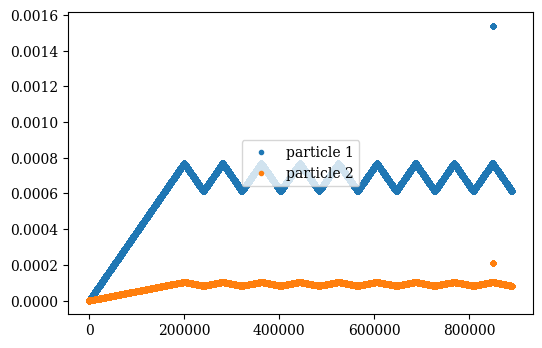

In [10]:
plt.plot(part1.index.get_level_values('frame'), part1['muz'], 'o', markersize = 3, label = 'particle 1')
plt.plot(part2.index.get_level_values('frame'), part2['muz'], 'o', markersize = 3, label = 'particle 2')

plt.legend(loc = 'center')
#plt.xlabel('time (s)', size = 12)
#plt.ylabel('magnetic moment (lammps units)', size = 12)
#plt.axvline(x = 2100000)
#plt.axvline(x= 7980000)
#plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

In [11]:
B_max = 138
B_min = 110
slope = 0.069
tim = []
t = [round(B_max/slope)]

def time(n):
    for i in range(1,n):
        t.append(round(((B_max-B_min)/slope+t[i-1])))
    for i in range(len(t)):
        tim.append(t[i]*100)
    return tim


t = time(18)
t

[200000,
 240600,
 281200,
 321800,
 362400,
 403000,
 443600,
 484200,
 524800,
 565400,
 606000,
 646600,
 687200,
 727800,
 768400,
 809000,
 849600,
 890200]

The behaviuor is what I expected, so the simulations worked fine. Now I can pass to point 2. 

### 1.2 Checking particles trajectories

In [12]:
# for i, trj_i in trj.groupby("id"):
#     plt.plot(trj_i.x, trj_i.y)

### 1.3 Checking the particles positions after each loop

The following loop will separate the particles data at the end of the cycle. 

In [13]:
part = trj.loc[trj['type'] < 3]

particles = []

for i in range(len(t)):
    if i % 2 == 0: # if i is even 
        particles.append(part.loc[[t[i]], ['x','y']])
        
    else:
        pass
#        particles.append(part.loc[[t[i]], ['x','y']])

part = pd.concat(particles, axis =0)
part

x           y
frame  id                         
200000 1     -0.050667   15.089100
       2     32.905800   17.723900
       3     65.969398   14.430800
       4     98.982101   14.771900
       5    131.945007   20.713699
...                ...         ...
849600 964  579.997009  693.073975
       965  612.135010  692.948975
       966  642.804993  692.971008
       967  678.953979  693.072021
       968  710.482971  692.937988

[8712 rows x 2 columns]

In [14]:
part.index.get_level_values('frame').unique()

Int64Index([200000, 281200, 362400, 443600, 524800, 606000, 687200, 768400,
            849600],
           dtype='int64', name='frame')

Adding the trap information

In [15]:
# short trap
d = a.loc[(abs(a['mux']) > 10), 'type'].unique()
# long trap
e = a.loc[(abs(a['muy']) > 10), 'type'].unique()

In [16]:
e

array([3])

In [17]:
trap_long = trj.loc[trj['type'] == e[0]] # Are the 30 um traps, those that contains particle 2
trap_short = trj.loc[trj['type'] == d[0]] # Are the 23 um traps, those that contains particle 1

In [18]:
trap_short

type      x      y    z   mux  muy  muz
frame  id                                           
0      1453     4   16.5    0.0  0.0 -23.0 -0.0 -0.0
       1454     4   49.5    0.0  0.0 -23.0 -0.0 -0.0
       1455     4   82.5    0.0  0.0  23.0  0.0  0.0
       1456     4  115.5    0.0  0.0 -23.0 -0.0 -0.0
       1457     4  148.5    0.0  0.0 -23.0 -0.0 -0.0
...           ...    ...    ...  ...   ...  ...  ...
890200 1932     4  577.5  693.0  0.0  23.0  0.0  0.0
       1933     4  610.5  693.0  0.0  23.0  0.0  0.0
       1934     4  643.5  693.0  0.0  23.0  0.0  0.0
       1935     4  676.5  693.0  0.0 -23.0 -0.0 -0.0
       1936     4  709.5  693.0  0.0  23.0  0.0  0.0

[4309052 rows x 7 columns]

In [19]:
def reordering_id(df):
    df = df.reset_index()
    df["id"] = df["id"]-min(df["id"])
    df = df.set_index(['frame', 'id'])
    del df['type']
    return df

In [20]:
t_short = reordering_id(trap_short)
t_long = reordering_id(trap_long)

In [21]:
t_short

x      y    z   mux  muy  muz
frame  id                                    
0      0     16.5    0.0  0.0 -23.0 -0.0 -0.0
       1     49.5    0.0  0.0 -23.0 -0.0 -0.0
       2     82.5    0.0  0.0  23.0  0.0  0.0
       3    115.5    0.0  0.0 -23.0 -0.0 -0.0
       4    148.5    0.0  0.0 -23.0 -0.0 -0.0
...           ...    ...  ...   ...  ...  ...
890200 479  577.5  693.0  0.0  23.0  0.0  0.0
       480  610.5  693.0  0.0  23.0  0.0  0.0
       481  643.5  693.0  0.0  23.0  0.0  0.0
       482  676.5  693.0  0.0 -23.0 -0.0 -0.0
       483  709.5  693.0  0.0  23.0  0.0  0.0

[4309052 rows x 6 columns]

In [22]:
short = trap_short.loc[trap_short.index.get_level_values('frame') == 0]
long = trap_long.loc[trap_long.index.get_level_values('frame') == 0]

In [23]:
from matplotlib.patches import Circle,Rectangle
from matplotlib.collections import PatchCollection

In [24]:
short

type      x      y    z   mux  muy  muz
frame id                                           
0     1453     4   16.5    0.0  0.0 -23.0 -0.0 -0.0
      1454     4   49.5    0.0  0.0 -23.0 -0.0 -0.0
      1455     4   82.5    0.0  0.0  23.0  0.0  0.0
      1456     4  115.5    0.0  0.0 -23.0 -0.0 -0.0
      1457     4  148.5    0.0  0.0 -23.0 -0.0 -0.0
...          ...    ...    ...  ...   ...  ...  ...
      1932     4  577.5  693.0  0.0  23.0  0.0  0.0
      1933     4  610.5  693.0  0.0  23.0  0.0  0.0
      1934     4  643.5  693.0  0.0  23.0  0.0  0.0
      1935     4  676.5  693.0  0.0 -23.0 -0.0 -0.0
      1936     4  709.5  693.0  0.0  23.0  0.0  0.0

[484 rows x 7 columns]

In [25]:
patches_l = []
patches_s = []
for index, row in long.iterrows():
    
    c_s = Circle((row['x'],row['y']+15.1779), radius=0.35, color = 'gray', alpha = 0.5)
    c_e = Circle((row['x'],row['y']-15.1779), radius=0.35, color = 'gray', alpha = 0.5)
    r = Rectangle((row['x']-0.35,row['y']-15.1779), width = 0.7 , height = 30.3558, angle=0)
    patches_l.extend((c_s,c_e,r))

for index, row in short.iterrows():   
    
    cs_s = Circle((row['x']+11.5,row['y']), radius=0.35, color = 'gray', alpha = 0.5)
    cs_e = Circle((row['x']-11.5,row['y']), radius=0.35, color = 'gray', alpha = 0.5)
    rs = Rectangle((row['x']-11.5,row['y']+0.35), width = 0.7 , height = 23, angle=-90)
    patches_s.extend((cs_s,cs_e,rs))

(50, 100)

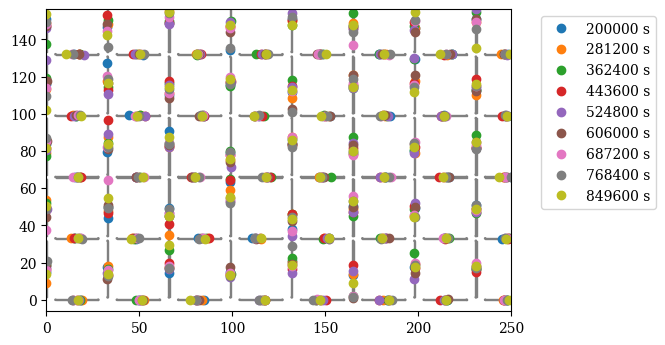

In [26]:
fig, ax = plt.subplots()
patches = patches_l + patches_s
p = PatchCollection(patches, alpha=1, color = 'gray')
ax.add_collection(p)

for i, trj_i in part.groupby("frame"):

    plt.plot(trj_i.x, trj_i.y, 'o', label = str(i)+' s')
    plt.axis('equal')
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0,250)
plt.ylim(50,100)
#plt.savefig('Snapshot_system_after_cycles_at_100mT.png', bbox_inches='tight')

## 2. Spin Overlap Parameter

### Attention! There is something weird

In [27]:
trap = trj.loc[trj['type'] > 2]
trap

type             x      y    z           mux        muy  muz
frame  id                                                                
0      969      3  1.010330e-15   16.5  0.0  1.858760e-15  30.355801  0.0
       970      3  3.300000e+01   16.5  0.0  1.858760e-15  30.355801  0.0
       971      3  6.600000e+01   16.5  0.0  1.858760e-15  30.355801  0.0
       972      3  9.900000e+01   16.5  0.0  1.858760e-15  30.355801  0.0
       973      3  1.320000e+02   16.5  0.0 -1.858760e-15 -30.355801 -0.0
...           ...           ...    ...  ...           ...        ...  ...
890200 1932     4  5.775000e+02  693.0  0.0  2.300000e+01   0.000000  0.0
       1933     4  6.105000e+02  693.0  0.0  2.300000e+01   0.000000  0.0
       1934     4  6.435000e+02  693.0  0.0  2.300000e+01   0.000000  0.0
       1935     4  6.765000e+02  693.0  0.0 -2.300000e+01  -0.000000 -0.0
       1936     4  7.095000e+02  693.0  0.0  2.300000e+01   0.000000  0.0

[8618104 rows x 7 columns]

I think that there is something wrong in the assignation of the 'mux' and 'muy' value. 

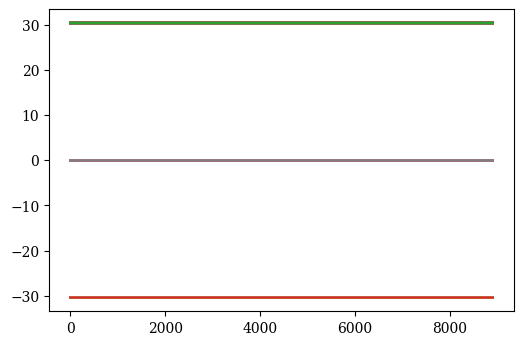

In [28]:
df = trap.groupby(['id'])
for i, (n, gr) in enumerate(df):
    plt.plot(gr['muy'].values, '-', )
#     plt.plot(gr.mux)

From this plot seems that spins are not correcly defined. The spins does not flip during the simulation eventhough in the particles trajectories we observe some flips.


### Trying to solve this:

I will try to extract with the information that I have the mux and muy value, as the following image shown, there is spin flips during the experiments.

In [29]:
t_short = reordering_id(trap_short)
t_long = reordering_id(trap_long)
p1 = reordering_id(part1)
p2 = reordering_id(part2)

In [30]:
t_short

x      y    z   mux  muy  muz
frame  id                                    
0      0     16.5    0.0  0.0 -23.0 -0.0 -0.0
       1     49.5    0.0  0.0 -23.0 -0.0 -0.0
       2     82.5    0.0  0.0  23.0  0.0  0.0
       3    115.5    0.0  0.0 -23.0 -0.0 -0.0
       4    148.5    0.0  0.0 -23.0 -0.0 -0.0
...           ...    ...  ...   ...  ...  ...
890200 479  577.5  693.0  0.0  23.0  0.0  0.0
       480  610.5  693.0  0.0  23.0  0.0  0.0
       481  643.5  693.0  0.0  23.0  0.0  0.0
       482  676.5  693.0  0.0 -23.0 -0.0 -0.0
       483  709.5  693.0  0.0  23.0  0.0  0.0

[4309052 rows x 6 columns]

In [31]:
p1

x           y    z  mux  muy       muz
frame  id                                                  
0      0      5.000000    0.000000  0.0  0.0  0.0  0.000000
       1     38.000000    0.000000  0.0  0.0  0.0  0.000000
       2     94.000000    0.000000  0.0  0.0  0.0  0.000000
       3    104.000000    0.000000  0.0  0.0  0.0  0.000000
       4    137.000000    0.000000  0.0  0.0  0.0  0.000000
...                ...         ...  ...  ...  ...       ...
890200 479  575.573975  692.898010  0.0  0.0  0.0  0.000613
       480  611.450989  692.940979  0.0  0.0  0.0  0.000613
       481  640.708008  692.989014  0.0  0.0  0.0  0.000613
       482  678.791992  693.078979  0.0  0.0  0.0  0.000613
       483  707.549988  692.955017  0.0  0.0  0.0  0.000613

[4309052 rows x 6 columns]

In [32]:
def filter_RPM_data(df,t):
    df_def = []
        
    for i in range(len(t)):
        if i % 2 == 0: # if i is even 
            
            df_def.append(df.loc[[t[i]]])
        else:
            pass
            #df_def.append(df.loc[[t[i]]])

    df_f = pd.concat(df_def, axis =0)
    return df_f

In [33]:
t_short = filter_RPM_data(t_short,t)
t_long = filter_RPM_data(t_long,t)
p1 = filter_RPM_data(p1,t)
p2 = filter_RPM_data(p2,t)

In [34]:
# # plt.plot(p1.x, p1.y , 'o', c ='blue', alpha = 0.1)
# # plt.plot(p2.x, p2.y , 'o', c ='blue', alpha = 0.1)
# # plt.plot(t_long.x, t_long.y , 'o', color = 'gray')
# plt.plot(t_short.x, t_short.y , 'o', color = 'gray', markersize = 10)
# plt.plot(t_shor.x, t_shor.y , 'o', color = 'blue', markersize = 5)
# # plt.plot(p1.x, p2.y , 'o', color = 'orange', markersize = 1)
# plt.axis('equal')

In [35]:
t_s = t_short.rename(columns={"x": "tx", "y": "ty", "z": "tz", "mux": "tmux", "muy": "tmuy", "muz" : "tmuz"})
t_l = t_long.rename(columns={"x": "tx", "y": "ty", "z": "tz", "mux": "tmux", "muy": "tmuy", "muz" : "tmuz"})
t_s

tx     ty   tz  tmux  tmuy  tmuz
frame  id                                      
200000 0     16.5    0.0  0.0 -23.0  -0.0  -0.0
       1     49.5    0.0  0.0 -23.0  -0.0  -0.0
       2     82.5    0.0  0.0  23.0   0.0   0.0
       3    115.5    0.0  0.0 -23.0  -0.0  -0.0
       4    148.5    0.0  0.0 -23.0  -0.0  -0.0
...           ...    ...  ...   ...   ...   ...
849600 479  577.5  693.0  0.0  23.0   0.0   0.0
       480  610.5  693.0  0.0  23.0   0.0   0.0
       481  643.5  693.0  0.0  23.0   0.0   0.0
       482  676.5  693.0  0.0 -23.0  -0.0  -0.0
       483  709.5  693.0  0.0  23.0   0.0   0.0

[4356 rows x 6 columns]

In [36]:
a  = pd.concat((p1,t_s), axis = 1)
b  = pd.concat((p2,t_l), axis = 1)

In [37]:
b.loc[(8400000),:].tail(50)

KeyError: 8400000

In [39]:
def del_col(df):
    del df["mux"]
    del df["muy"]
    del df["muz"]

    del df["tmux"]
    del df["tmuy"]
    del df["tmuz"]
    return df

In [40]:
a = del_col(a)
b = del_col(b)

In [41]:
a['resX'] = a["x"]-a["tx"]
b['resY'] = b["y"]-b["ty"]

### Trying new things

In [72]:
a['d'] = np.sqrt((a["x"]-a["tx"])**2)
b['d'] = np.sqrt((b["y"]-b["ty"])**2)

In [73]:
tb = b.groupby('frame').mean()
tb['d'] = tb.d/tb.loc[200000,'d']

In [74]:
tb.loc[200000,'d']

1.0

In [75]:
tb

,x,y,z,tx,ty,tz,resY,d
frame,,,,,,,,
200000,346.498962,363.000641,0.0,346.5,363.0,0.0,0.000638,1.000000
281200,346.505096,362.853882,0.0,346.5,363.0,0.0,-0.146130,0.921602
362400,346.505219,361.516724,0.0,346.5,363.0,0.0,-1.483277,1.345558
443600,346.503448,362.941071,0.0,346.5,363.0,0.0,-0.058934,0.863203
524800,346.501404,361.249542,0.0,346.5,363.0,0.0,-1.750459,1.291658
606000,346.499390,361.363922,0.0,346.5,363.0,0.0,-1.636088,1.320136
687200,346.497711,362.884705,0.0,346.5,363.0,0.0,-0.115286,0.926478
768400,346.499237,360.152039,0.0,346.5,363.0,0.0,-2.847959,1.717358
849600,346.499847,363.056366,0.0,346.5,363.0,0.0,0.056356,0.979258


In [76]:
t = a.groupby('frame').mean()
t

,x,y,z,tx,ty,tz,resX,d
frame,,,,,,,,
200000,363.030426,346.506378,0.0,363.0,346.5,0.0,0.030419,1.860258
281200,363.056580,346.497864,0.0,363.0,346.5,0.0,0.056565,1.673444
362400,363.060516,346.502258,0.0,363.0,346.5,0.0,0.060524,1.744092
443600,362.992950,346.499756,0.0,363.0,346.5,0.0,-0.007054,1.657260
524800,363.009369,346.494110,0.0,363.0,346.5,0.0,0.009378,1.633154
606000,362.878601,346.496765,0.0,363.0,346.5,0.0,-0.121387,1.695627
687200,363.008545,346.496582,0.0,363.0,346.5,0.0,0.008534,1.712072
768400,363.004181,346.499115,0.0,363.0,346.5,0.0,0.004193,1.674443
849600,362.984741,346.508636,0.0,363.0,346.5,0.0,-0.015250,1.708730


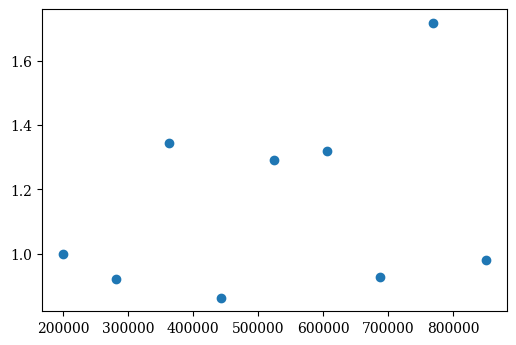

In [77]:
plt.plot(tb.index.get_level_values('frame'), tb.d, 'o')
#plt.plot(t.index.get_level_values('frame'), t.d, 'o')

### END

In [43]:
a["spin"] = np.NaN
b["spin"] = np.NaN
a.loc[a.resX > 0, "spin"] = 1
a.loc[a.resX < 0, "spin"] = -1
b.loc[b.resY > 0, "spin"] = 1
b.loc[b.resY < 0, "spin"] = -1

In [44]:
a.tail(50)

x           y    z     tx     ty   tz      resX  spin
frame  id                                                                 
849600 434  543.356995  626.898010  0.0  544.5  627.0  0.0 -1.143005  -1.0
       435  578.765991  627.044983  0.0  577.5  627.0  0.0  1.265991   1.0
       436  609.280029  626.931030  0.0  610.5  627.0  0.0 -1.219971  -1.0
       437  640.853027  627.078979  0.0  643.5  627.0  0.0 -2.646973  -1.0
       438  676.635010  627.064026  0.0  676.5  627.0  0.0  0.135010   1.0
       439  707.934021  626.703979  0.0  709.5  627.0  0.0 -1.565979  -1.0
       440   15.040100  660.031982  0.0   16.5  660.0  0.0 -1.459900  -1.0
       441   52.897202  660.018982  0.0   49.5  660.0  0.0  3.397202   1.0
       442   83.287300  660.101013  0.0   82.5  660.0  0.0  0.787300   1.0
       443  114.768997  660.078003  0.0  115.5  660.0  0.0 -0.731003  -1.0
       444  146.826996  659.830994  0.0  148.5  660.0  0.0 -1.673004  -1.0
       445  183.169006  659.916992  0.0  181.5  660.0  0.0  1.669006   1.0
       446  214.615997  659.927002  0.0  214.5  660.0  0.0  0.115997   1.0
       447  244.731003  659.929016  0.0  247.5  660.0  0.0 -2.768997  -1.0
       448  284.303009  660.065979  0.0  280.5  660.0  0.0  3.803009   1.0
       449  313.265991  659.974976  0.0  313.5  660.0  0.0 -0.234009  -1.0
       450  347.523987  659.906982  0.0  346.5  660.0  0.0  1.023987   1.0
       451  376.808990  659.831970  0.0  379.5  660.0  0.0 -2.691010  -1.0
       452  417.476990  659.888977  0.0  412.5  660.0  0.0  4.976990   1.0
       453  446.578003  660.049988  0.0  445.5  660.0  0.0  1.078003   1.0
       454  477.783997  659.935974  0.0  478.5  660.0  0.0 -0.716003  -1.0
       455  507.386993  660.111023  0.0  511.5  660.0  0.0 -4.113007  -1.0
       456  546.838989  660.041016  0.0  544.5  660.0  0.0  2.338989   1.0
       457  576.041016  660.133972  0.0  577.5  660.0  0.0 -1.458984  -1.0
       458  607.711975  659.956970  0.0  610.5  660.0  0.0 -2.788025  -1.0
       459  640.754028  659.994019  0.0  643.5  660.0  0.0 -2.745972  -1.0
       460  671.544983  660.005005  0.0  676.5  660.0  0.0 -4.955017  -1.0
       461  710.864014  659.956970  0.0  709.5  660.0  0.0  1.364014   1.0
       462   14.900800  693.098022  0.0   16.5  693.0  0.0 -1.599200  -1.0
       463   46.605400  693.062988  0.0   49.5  693.0  0.0 -2.894600  -1.0
       464   86.456497  693.052979  0.0   82.5  693.0  0.0  3.956497   1.0
       465  116.778000  692.797974  0.0  115.5  693.0  0.0  1.278000   1.0
       466  150.520996  693.017029  0.0  148.5  693.0  0.0  2.020996   1.0
       467  181.203003  692.939026  0.0  181.5  693.0  0.0 -0.296997  -1.0
       468  213.348007  693.062988  0.0  214.5  693.0  0.0 -1.151993  -1.0
       469  246.634003  693.051025  0.0  247.5  693.0  0.0 -0.865997  -1.0
       470  277.976990  693.026001  0.0  280.5  693.0  0.0 -2.523010  -1.0
       471  315.358002  692.958008  0.0  313.5  693.0  0.0  1.858002   1.0
       472  343.691986  693.044983  0.0  346.5  693.0  0.0 -2.808014  -1.0
       473  382.671997  692.940979  0.0  379.5  693.0  0.0  3.171997   1.0
       474  412.367004  692.914001  0.0  412.5  693.0  0.0 -0.132996  -1.0
       475  444.721008  692.953003  0.0  445.5  693.0  0.0 -0.778992  -1.0
       476  478.234009  693.041016  0.0  478.5  693.0  0.0 -0.265991  -1.0
       477  513.224976  692.965027  0.0  511.5  693.0  0.0  1.724976   1.0
       478  542.421021  692.942017  0.0  544.5  693.0  0.0 -2.078979  -1.0
       479  579.997009  693.073975  0.0  577.5  693.0  0.0  2.497009   1.0
       480  612.135010  692.948975  0.0  610.5  693.0  0.0  1.635010   1.0
       481  642.804993  692.971008  0.0  643.5  693.0  0.0 -0.695007  -1.0
       482  678.953979  693.072021  0.0  676.5  693.0  0.0  2.453979   1.0
       483  710.482971  692.937988  0.0  709.5  693.0  0.0  0.982971   1.0

Here I have the spin values of the horizontal traps for all the frames.

In [45]:
a = a.drop(columns=["x", "tx", "y", "ty", "z", "tz", "resX"])
b = b.drop(columns=["x", "tx", "y", "ty", "z", "tz", "resY"])

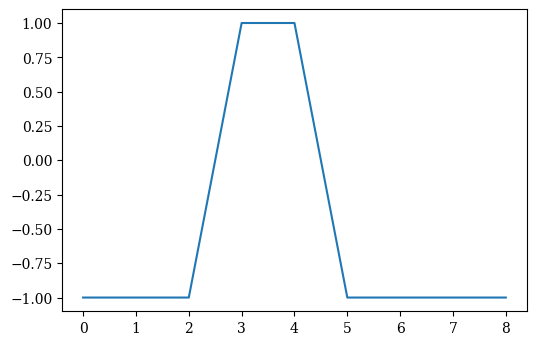

In [46]:
df = a.groupby(['id'])
for i, (n, gr) in enumerate(df):
    if n == 4:
        plt.plot(gr['spin'].values, '-')

### Now we see flips of the particles!!!

I think that the better that I can do if to save the data and start the Spin Overlap Parameter en a new script. 

In [92]:
df_short = filter_RPM_data(a,t)
df_long = filter_RPM_data(b,t)

In [93]:
df_short.tail(50)

spin
frame   id       
7980000 434   1.0
        435  -1.0
        436  -1.0
        437  -1.0
        438   1.0
        439   1.0
        440  -1.0
        441   1.0
        442  -1.0
        443   1.0
        444  -1.0
        445  -1.0
        446   1.0
        447   1.0
        448   1.0
        449   1.0
        450  -1.0
        451   1.0
        452   1.0
        453  -1.0
        454   1.0
        455   1.0
        456  -1.0
        457   1.0
        458  -1.0
        459   1.0
        460  -1.0
        461  -1.0
        462  -1.0
        463  -1.0
        464   1.0
        465  -1.0
        466  -1.0
        467   1.0
        468   1.0
        469   1.0
        470  -1.0
        471  -1.0
        472   1.0
        473  -1.0
        474   1.0
        475   1.0
        476  -1.0
        477  -1.0
        478   1.0
        479  -1.0
        480   1.0
        481   1.0
        482   1.0
        483  -1.0

In [46]:
#save_dir = 'Data_RPM'

In [47]:
#df_short.to_csv(os.path.join(save_dir,'Spins_short_100mT_EXP'+str(k)), sep = '\t')
#df_long.to_csv(os.path.join(save_dir,'Spins_long_100mT_EXP'+str(k)), sep = '\t')

# to do:
    
    - Find a way to do the trying to solve this paragraph in a loop of all the experiments.
        (Maybe is not necessary to save all the frames but only the interesting ones)
    - Save the data.
    - Compute the Spin Overlap Parameter